In [651]:
#Instalen esto para simplificar strings (Servirá para homogeneizar las comunas)

In [652]:
!pip install unidecode


In [653]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## Importar datos

In [654]:
data = pd.read_csv("2023-03-08 Precios Casas RM.csv") #Dataset de precios
comunas = pd.read_csv("Latitud - Longitud Chile.csv") #Dataset de comunas

## Feature engineering + EDA

In [655]:
#Veamos qué tal se ven las comunas
comunas = comunas[comunas["Región"] == "Metropolitana de Santiago"] #Seleccionamos las comunas que están en santiago
comunas.Comuna.unique() #Fíjense en cómo están escritas, con espacios y tildes. 

array(['Santiago', 'Cerrillos', 'Cerro Navia', 'Conchalí', 'El Bosque',
       'Estación Central', 'Huechuraba', 'Independencia', 'La Cisterna',
       'La Florida', 'La Granja', 'La Pintana', 'La Reina', 'Las Condes',
       'Lo Barnechea', 'Lo Espejo', 'Lo Prado', 'Macul', 'Maipú', 'Ñuñoa',
       'Pedro Aguirre Cerda', 'Peñalolén', 'Providencia', 'Pudahuel',
       'Quilicura', 'Quinta Normal', 'Recoleta', 'Renca', 'San Joaquín',
       'San Miguel', 'San Ramón', 'Vitacura', 'Puente Alto', 'Pirque',
       'San José de Maipo', 'Colina', 'Lampa', 'Til Til', 'San Bernardo',
       'Buin', 'Calera de Tango', 'Paine', 'Melipilla', 'Alhué',
       'Curacaví', 'María Pinto', 'San Pedro', 'Talagante', 'El Monte',
       'Isla de Maipo', 'Padre Hurtado', 'Peñaflor'], dtype=object)

In [656]:
#Primero vamos a transformar los string en el dataset de comunas
comunas["Comuna"] = comunas.Comuna.str.replace(" ", "") #Vamos a quitarles los espacios
comunas["Comuna"] = comunas["Comuna"].apply(unidecode) #Quitamos caracteres extraños como tildes
comunas["Comuna"] = comunas["Comuna"].str.lower() #Dejamos en minusculas
comunas.head()

,CUT (Código Único Territorial),Comuna,Provincia,Región,Superficie (km2),Población Año 2017,Densidad (hab./km2),IDH 2005,Latitud (Decimal),Longitud (decimal),Latitud (Sexagesimal),Longitud (Sexagesimal)
257,13101,santiago,Santiago,Metropolitana de Santiago,23.20,"404,495",17435.1,0.807,-33.4372,-70.6572,"-33°26' 14""","-70°39' 26"""
258,13102,cerrillos,Santiago,Metropolitana de Santiago,21.00,"80,832",3849.1,0.743,-33.5000,-70.7167,"-33°30' 0""","-70°43' 0"""
259,13103,cerronavia,Santiago,Metropolitana de Santiago,11.00,"132,622",12056.5,0.683,-33.4219,-70.7350,-33°25' 19'',"-70°44' 6"""
260,13104,conchali,Santiago,Metropolitana de Santiago,10.70,"126,955",11865.0,0.707,-33.3800,-70.6750,"-33°22' 48""","-70°40' 30"""
261,13105,elbosque,Santiago,Metropolitana de Santiago,14.20,"162,505",11444.0,0.711,-33.5669,-70.6750,-33°34' 1'',"-70°40' 30"""


In [657]:
#Ahora en el dataset de precios
data["Comuna"] = data["Comuna"].apply(unidecode) #Quitamos caracteres extraños
data["Comuna"] = data["Comuna"].str.lower() #Dejamos en minusculas
data

,Price_CLP,Price_UF,Price_USD,Comuna,Ubicacion,Dorms,Baths,Built Area,Total Area,Parking,id,Realtor
0,409285000,11500,509695,quintanormal,Hoevel4548y4558,7,4.0,384.0,732.0,3.0,11700213,NaN
1,105000000,2950,130760,pedroaguirrecerda,Rucalhue,2,1.0,112.0,145.0,1.0,10894299,Legales y Propiedades SpA
2,128124000,3600,159557,estacioncentral,AvenidaLasParcelas,3,1.0,59.0,243.0,2.0,10257635,Propiedadesrs
3,75000000,2107,93400,colina,PasajeGonzaloRojas,3,1.0,103.0,73.0,1.0,9232092,Patricio Gajardo propiedades
4,53000000,1489,66002,colina,HernánDíazArrieta2820,2,1.0,57.0,67.0,1.0,7085397,Patricio Gajardo propiedades
...,...,...,...,...,...,...,...,...,...,...,...,...
7774,2491300000,70000,3102491,lascondes,CalleSanJosédeLaSierra,5,5.0,600.0,1800.0,5.0,4708915,Propiedades Viña Limitada ®
7775,242012000,6800,301385,penalolen,PasajeMarNegro,4,2.0,124.0,200.0,1.0,6641660,NaN
7776,3736950000,105000,4653736,lascondes,CaminoLasFlores/CaminoPiedraRoja,5,7.0,460.0,4925.0,8.0,6032811,Tsi Property
7777,569440000,16000,709141,lapintana,LosCipreses/LosDuraznos,4,2.0,311.0,2011.0,1.0,5314376,Tsi Property


In [658]:
data = data.merge(comunas, on="Comuna", how="left")
data

,Price_CLP,Price_UF,Price_USD,Comuna,Ubicacion,Dorms,Baths,Built Area,Total Area,Parking,...,Provincia,Región,Superficie (km2),Población Año 2017,Densidad (hab./km2),IDH 2005,Latitud (Decimal),Longitud (decimal),Latitud (Sexagesimal),Longitud (Sexagesimal)
0,409285000,11500,509695,quintanormal,Hoevel4548y4558,7,4.0,384.0,732.0,3.0,...,Santiago,Metropolitana de Santiago,13.00,"110,026",8463.5,0.723,-33.4269,-70.6989,-33°25' 37'',-70°41' 56''
1,105000000,2950,130760,pedroaguirrecerda,Rucalhue,2,1.0,112.0,145.0,1.0,...,Santiago,Metropolitana de Santiago,10.00,"101,174",10117.4,0.708,-33.4661,-70.6336,-33°27' 58'',-70°38' 1''
2,128124000,3600,159557,estacioncentral,AvenidaLasParcelas,3,1.0,59.0,243.0,2.0,...,Santiago,Metropolitana de Santiago,15.00,"147,041",9802.7,0.735,-33.4589,-70.6989,-33°27' 32'',-70°41' 56''
3,75000000,2107,93400,colina,PasajeGonzaloRojas,3,1.0,103.0,73.0,1.0,...,Chacabuco,Metropolitana de Santiago,971.20,"146,207",150.5,0.726,-33.1939,-70.6678,-33°11' 38'',-70°40' 4''
4,53000000,1489,66002,colina,HernánDíazArrieta2820,2,1.0,57.0,67.0,1.0,...,Chacabuco,Metropolitana de Santiago,971.20,"146,207",150.5,0.726,-33.1939,-70.6678,-33°11' 38'',-70°40' 4''
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7774,2491300000,70000,3102491,lascondes,CalleSanJosédeLaSierra,5,5.0,600.0,1800.0,5.0,...,Santiago,Metropolitana de Santiago,99.00,"294,838",2978.2,0.933,-33.4167,-70.5833,"-33°25' 0""","-70°35' 0"""
7775,242012000,6800,301385,penalolen,PasajeMarNegro,4,2.0,124.0,200.0,1.0,...,Santiago,Metropolitana de Santiago,54.00,"241,599",4474.1,0.743,-33.4861,-70.5333,-33°29' 10'',"-70°32' 0"""
7776,3736950000,105000,4653736,lascondes,CaminoLasFlores/CaminoPiedraRoja,5,7.0,460.0,4925.0,8.0,...,Santiago,Metropolitana de Santiago,99.00,"294,838",2978.2,0.933,-33.4167,-70.5833,"-33°25' 0""","-70°35' 0"""
7777,569440000,16000,709141,lapintana,LosCipreses/LosDuraznos,4,2.0,311.0,2011.0,1.0,...,Santiago,Metropolitana de Santiago,30.60,"177,335",5795.3,0.679,-33.5828,-70.6339,-33°34' 58'',-70°38' 2''


In [659]:
#Eliminemos algunas columnas inutiles y estandaricemos los nombres de las columnas
data = data.drop(columns=["Price_CLP", "Price_USD", "id", "Realtor", "CUT (Código Único Territorial)",
                          "Provincia", "Región", "Ubicacion", "Latitud (Sexagesimal)", "Longitud (Sexagesimal)"])
data.columns=["price", "comuna", "dorms", "baths", "built_area", "total_area", "parking", "superficie_comuna", "poblacion_comuna", "densidad_comuna", "idh_comuna", "lat_comuna", "long_comuna" ]
data

,price,comuna,dorms,baths,built_area,total_area,parking,superficie_comuna,poblacion_comuna,densidad_comuna,idh_comuna,lat_comuna,long_comuna
0,11500,quintanormal,7,4.0,384.0,732.0,3.0,13.00,"110,026",8463.5,0.723,-33.4269,-70.6989
1,2950,pedroaguirrecerda,2,1.0,112.0,145.0,1.0,10.00,"101,174",10117.4,0.708,-33.4661,-70.6336
2,3600,estacioncentral,3,1.0,59.0,243.0,2.0,15.00,"147,041",9802.7,0.735,-33.4589,-70.6989
3,2107,colina,3,1.0,103.0,73.0,1.0,971.20,"146,207",150.5,0.726,-33.1939,-70.6678
4,1489,colina,2,1.0,57.0,67.0,1.0,971.20,"146,207",150.5,0.726,-33.1939,-70.6678
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7774,70000,lascondes,5,5.0,600.0,1800.0,5.0,99.00,"294,838",2978.2,0.933,-33.4167,-70.5833
7775,6800,penalolen,4,2.0,124.0,200.0,1.0,54.00,"241,599",4474.1,0.743,-33.4861,-70.5333
7776,105000,lascondes,5,7.0,460.0,4925.0,8.0,99.00,"294,838",2978.2,0.933,-33.4167,-70.5833
7777,16000,lapintana,4,2.0,311.0,2011.0,1.0,30.60,"177,335",5795.3,0.679,-33.5828,-70.6339


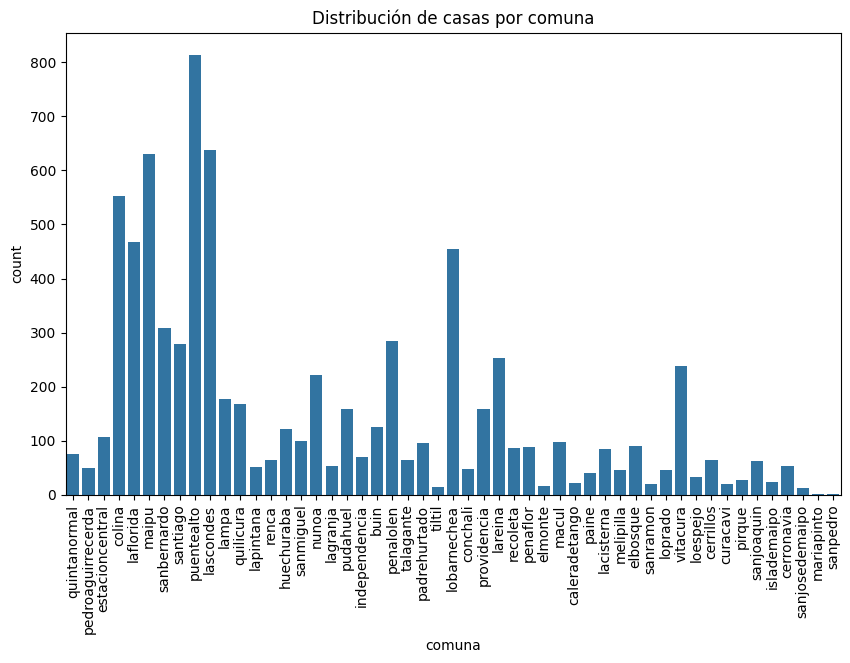

In [660]:
plt.figure(figsize=(10,6))
sns.countplot(data, x="comuna") #Cuenta cuantas comunas hay en el dataset
plt.title("Distribución de casas por comuna") #El título
plt.xticks(rotation=90) #Rota los nombres de las comunas para que quepan en el plot
plt.show()

In [661]:
data.describe() #Describamos los datos numéricos

,price,dorms,baths,built_area,total_area,parking,densidad_comuna,idh_comuna,lat_comuna,long_comuna
count,7779.000000,7779.000000,7714.000000,7533.000000,7571.000000,5489.000000,7779.000000,7779.000000,7779.000000,7779.000000
mean,10234.571153,3.994087,2.653746,229.923669,807.919826,2.980506,5022.160352,0.801947,-33.466522,-70.648303
std,10870.491584,1.622821,1.465103,1676.898812,9050.893115,17.749384,4451.350901,0.083812,0.122765,0.109601
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.640000,0.657000,-33.900000,-71.466700
25%,3372.000000,3.000000,2.000000,85.000000,129.500000,1.000000,1943.900000,0.726000,-33.528900,-70.698900
50%,5760.000000,4.000000,2.000000,128.000000,210.000000,2.000000,3849.600000,0.773000,-33.453900,-70.633900
75%,13800.000000,5.000000,3.000000,200.000000,443.000000,3.000000,6455.800000,0.902000,-33.405800,-70.570000
max,155000.000000,27.000000,29.000000,120000.000000,678000.000000,1269.000000,17435.100000,0.949000,-33.085000,-70.352800


In [662]:
data = data.drop(columns=["comuna"]) #Borra las comunas para quedarnos solo con valores numéricos
data #Vemos que hay valores nulos, además hay algunos valores que sabemos que son numéricos, que tienen una "," y otros un "." (densidad_comuna, poblacion_comuna)

,price,dorms,baths,built_area,total_area,parking,superficie_comuna,poblacion_comuna,densidad_comuna,idh_comuna,lat_comuna,long_comuna
0,11500,7,4.0,384.0,732.0,3.0,13.00,"110,026",8463.5,0.723,-33.4269,-70.6989
1,2950,2,1.0,112.0,145.0,1.0,10.00,"101,174",10117.4,0.708,-33.4661,-70.6336
2,3600,3,1.0,59.0,243.0,2.0,15.00,"147,041",9802.7,0.735,-33.4589,-70.6989
3,2107,3,1.0,103.0,73.0,1.0,971.20,"146,207",150.5,0.726,-33.1939,-70.6678
4,1489,2,1.0,57.0,67.0,1.0,971.20,"146,207",150.5,0.726,-33.1939,-70.6678
...,...,...,...,...,...,...,...,...,...,...,...,...
7774,70000,5,5.0,600.0,1800.0,5.0,99.00,"294,838",2978.2,0.933,-33.4167,-70.5833
7775,6800,4,2.0,124.0,200.0,1.0,54.00,"241,599",4474.1,0.743,-33.4861,-70.5333
7776,105000,5,7.0,460.0,4925.0,8.0,99.00,"294,838",2978.2,0.933,-33.4167,-70.5833
7777,16000,4,2.0,311.0,2011.0,1.0,30.60,"177,335",5795.3,0.679,-33.5828,-70.6339


In [663]:
data.dtypes #Fíjense que si vemos los tipos de datos: poblacion y superficie tienen tipo "object". Eso indica que están como texto

price                  int64
dorms                  int64
baths                float64
built_area           float64
total_area           float64
parking              float64
superficie_comuna     object
poblacion_comuna      object
densidad_comuna      float64
idh_comuna           float64
lat_comuna           float64
long_comuna          float64
dtype: object

In [664]:
def parse_column_to_float(data, column):
    data[column] = data[column].str.replace(" ", "") #Vamos a eliminar espacios " "
    data[column] = data[column].str.replace(",", "") #Vamos a eliminar comas
    data[column] = data[column].astype(float) #Vamos a transformar a float
    return data

parse_column_to_float(data, "superficie_comuna")
parse_column_to_float(data, "poblacion_comuna")

,price,dorms,baths,built_area,total_area,parking,superficie_comuna,poblacion_comuna,densidad_comuna,idh_comuna,lat_comuna,long_comuna
0,11500,7,4.0,384.0,732.0,3.0,13.0,110026.0,8463.5,0.723,-33.4269,-70.6989
1,2950,2,1.0,112.0,145.0,1.0,10.0,101174.0,10117.4,0.708,-33.4661,-70.6336
2,3600,3,1.0,59.0,243.0,2.0,15.0,147041.0,9802.7,0.735,-33.4589,-70.6989
3,2107,3,1.0,103.0,73.0,1.0,971.2,146207.0,150.5,0.726,-33.1939,-70.6678
4,1489,2,1.0,57.0,67.0,1.0,971.2,146207.0,150.5,0.726,-33.1939,-70.6678
...,...,...,...,...,...,...,...,...,...,...,...,...
7774,70000,5,5.0,600.0,1800.0,5.0,99.0,294838.0,2978.2,0.933,-33.4167,-70.5833
7775,6800,4,2.0,124.0,200.0,1.0,54.0,241599.0,4474.1,0.743,-33.4861,-70.5333
7776,105000,5,7.0,460.0,4925.0,8.0,99.0,294838.0,2978.2,0.933,-33.4167,-70.5833
7777,16000,4,2.0,311.0,2011.0,1.0,30.6,177335.0,5795.3,0.679,-33.5828,-70.6339


In [665]:
data.dtypes #Ahora si hay sólo valores numéricos

price                  int64
dorms                  int64
baths                float64
built_area           float64
total_area           float64
parking              float64
superficie_comuna    float64
poblacion_comuna     float64
densidad_comuna      float64
idh_comuna           float64
lat_comuna           float64
long_comuna          float64
dtype: object

In [666]:
data.describe() #Genial :D 

,price,dorms,baths,built_area,total_area,parking,superficie_comuna,poblacion_comuna,densidad_comuna,idh_comuna,lat_comuna,long_comuna
count,7779.000000,7779.000000,7714.000000,7533.000000,7571.000000,5489.000000,7779.000000,7779.000000,7779.000000,7779.000000,7779.000000,7779.000000
mean,10234.571153,3.994087,2.653746,229.923669,807.919826,2.980506,223.045443,252498.699319,5022.160352,0.801947,-33.466522,-70.648303
std,10870.491584,1.622821,1.465103,1676.898812,9050.893115,17.749384,381.107019,169093.502147,4451.350901,0.083812,0.122765,0.109601
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,9726.000000,3.640000,0.657000,-33.900000,-71.466700
25%,3372.000000,3.000000,2.000000,85.000000,129.500000,1.000000,23.200000,105833.000000,1943.900000,0.726000,-33.528900,-70.698900
50%,5760.000000,4.000000,2.000000,128.000000,210.000000,2.000000,88.000000,208237.000000,3849.600000,0.773000,-33.453900,-70.633900
75%,13800.000000,5.000000,3.000000,200.000000,443.000000,3.000000,155.000000,366916.000000,6455.800000,0.902000,-33.405800,-70.570000
max,155000.000000,27.000000,29.000000,120000.000000,678000.000000,1269.000000,4994.800000,568106.000000,17435.100000,0.949000,-33.085000,-70.352800


In [667]:
#Veamos si tenemos valores nulos
def count_nulls(data):
    for column in data.columns: #Iterar las columnas
        print(column, len(data[data[column].isna()])) #Ver la cantidad de nulos
count_nulls(data)

price 0
dorms 0
baths 65
built_area 246
total_area 208
parking 2290
superficie_comuna 0
poblacion_comuna 0
densidad_comuna 0
idh_comuna 0
lat_comuna 0
long_comuna 0


In [668]:
#Vamos a ver qué podemos hacer para tratar los nulos.
#Primero, no hay casas sin baño XD así que no le podemos asignar el valor 0
data.corr()["poblacion_comuna"].sort_values(ascending=False) #Calculamos la correlación y ordenamos de forma descendente
#Fíjense que existe una correlación fuerte entre la cantidad de dormitorios y la cantidad de baños. 

poblacion_comuna     1.000000
idh_comuna           0.191556
densidad_comuna      0.178561
long_comuna          0.148461
built_area          -0.026406
parking             -0.033939
total_area          -0.041990
dorms               -0.133243
baths               -0.201133
price               -0.267400
superficie_comuna   -0.269063
lat_comuna          -0.401466
Name: poblacion_comuna, dtype: float64

(0.0, 10.5)

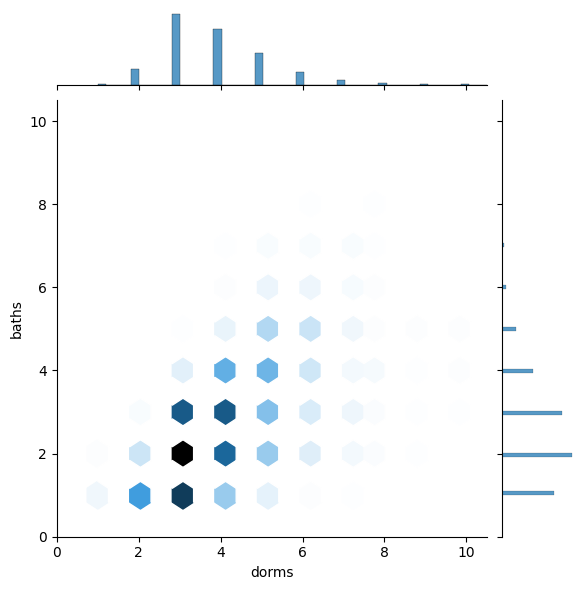

In [669]:
#Vamos a ver cómo se distribuyen los baños en relación a la cantidad de dormitorios
sns.jointplot(data, x="dorms", y="baths", kind="hex")
plt.xlim(0, 10.5)
plt.ylim(0, 10.5)
#Efectivamente se ve una tendencia positiva

In [670]:
print(data.isnull().sum())

price                   0
dorms                   0
baths                  65
built_area            246
total_area            208
parking              2290
superficie_comuna       0
poblacion_comuna        0
densidad_comuna         0
idh_comuna              0
lat_comuna              0
long_comuna             0
dtype: int64


<Axes: ylabel='dorms'>

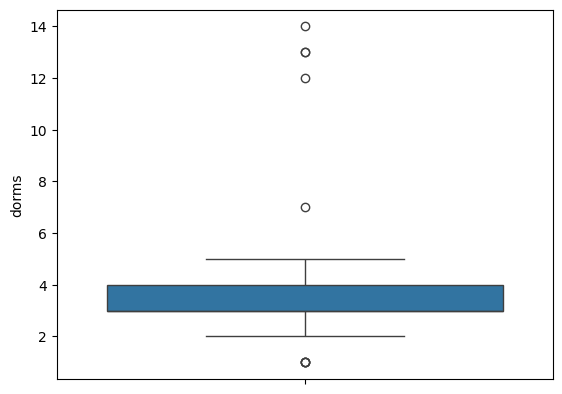

In [671]:

sns.boxplot(data[data.baths.isna()], y="dorms", showfliers=True) #La distribución de filas sin baño está centrada entre 2 y 5 dormitorios. Sin considerar los outliers. 
#Podemos solucionar estos casos y el resto descartar por ser outliers.

In [672]:
data1 = data[data.baths.isna()]
print(data1["dorms"].max())
data1.describe()

14


,price,dorms,baths,built_area,total_area,parking,superficie_comuna,poblacion_comuna,densidad_comuna,idh_comuna,lat_comuna,long_comuna
count,65.000000,65.000000,0.0,50.000000,51.000000,26.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.00000
mean,12537.046154,3.830769,NaN,1564.000000,1910.490196,3.423077,287.416923,241285.430769,6126.183692,0.786323,-33.471689,-70.62874
std,14945.124785,2.631357,NaN,8468.790683,8366.943546,3.900493,690.184599,171776.021091,4744.514554,0.077410,0.128154,0.09050
min,1290.000000,1.000000,NaN,1.000000,55.000000,1.000000,9.700000,18189.000000,3.640000,0.683000,-33.811900,-70.93080
25%,3372.000000,3.000000,NaN,84.000000,159.500000,1.000000,15.000000,105833.000000,2978.200000,0.726000,-33.566900,-70.67500
50%,5339.000000,3.000000,NaN,137.500000,235.000000,2.500000,70.200000,147041.000000,5226.700000,0.773000,-33.486100,-70.62780
75%,15000.000000,4.000000,NaN,345.000000,954.000000,3.000000,135.500000,366916.000000,9741.400000,0.807000,-33.405800,-70.57000
max,60000.000000,14.000000,NaN,60000.000000,60000.000000,20.000000,4994.800000,568106.000000,17435.100000,0.949000,-33.193900,-70.35280


In [673]:
data.loc[(data["baths"].isna()) & (data["dorms"] == 2), "baths"] = 1 #Si tiene dos dormitorios, diremos que tiene 1 baño
data.loc[(data["baths"].isna()) & (data["dorms"] == 3), "baths"] = 2 #Si tiene dos dormitorios, diremos que tiene 1 baño
data.loc[(data["baths"].isna()) & (data["dorms"] == 4), "baths"] = 3 #Si tiene dos dormitorios, diremos que tiene 1 baño
data.loc[(data["baths"].isna()) & (data["dorms"] == 5), "baths"] = 4 #Si tiene dos dormitorios, diremos que tiene 1 baño
data[data.baths.isna()] #Entonces, estos serían nuestros valores outlier que no nos interesa mucho utilizar

,price,dorms,baths,built_area,total_area,parking,superficie_comuna,poblacion_comuna,densidad_comuna,idh_comuna,lat_comuna,long_comuna
784,60000,14,NaN,60000.0,60000.0,NaN,4994.8,18189.0,3.64,0.759,-33.6439,-70.3528
1077,8500,13,NaN,350.0,198.0,NaN,16.0,157851.0,9865.70,0.697,-33.4058,-70.6400
1078,8500,13,NaN,350.0,198.0,NaN,16.0,157851.0,9865.70,0.697,-33.4058,-70.6400
1926,18390,1,NaN,1.0,613.0,NaN,23.2,404495.0,17435.10,0.807,-33.4372,-70.6572
2652,2107,1,NaN,NaN,NaN,NaN,23.2,404495.0,17435.10,0.807,-33.4372,-70.6572
2788,3934,12,NaN,270.0,480.0,NaN,11.0,132622.0,12056.50,0.683,-33.4219,-70.7350
5251,26887,7,NaN,500.0,1760.0,NaN,12.9,116534.0,9033.60,0.806,-33.4869,-70.6039
6005,3512,1,NaN,170.0,170.0,1.0,9.7,94492.0,9741.40,0.719,-33.4908,-70.6278
6045,15000,1,NaN,127.0,2945.0,3.0,971.2,146207.0,150.50,0.726,-33.1939,-70.6678


In [674]:
#Removemos los nulos de los baños que no fueron inputados
data = data[data.baths.notna()]
data

,price,dorms,baths,built_area,total_area,parking,superficie_comuna,poblacion_comuna,densidad_comuna,idh_comuna,lat_comuna,long_comuna
0,11500,7,4.0,384.0,732.0,3.0,13.0,110026.0,8463.5,0.723,-33.4269,-70.6989
1,2950,2,1.0,112.0,145.0,1.0,10.0,101174.0,10117.4,0.708,-33.4661,-70.6336
2,3600,3,1.0,59.0,243.0,2.0,15.0,147041.0,9802.7,0.735,-33.4589,-70.6989
3,2107,3,1.0,103.0,73.0,1.0,971.2,146207.0,150.5,0.726,-33.1939,-70.6678
4,1489,2,1.0,57.0,67.0,1.0,971.2,146207.0,150.5,0.726,-33.1939,-70.6678
...,...,...,...,...,...,...,...,...,...,...,...,...
7774,70000,5,5.0,600.0,1800.0,5.0,99.0,294838.0,2978.2,0.933,-33.4167,-70.5833
7775,6800,4,2.0,124.0,200.0,1.0,54.0,241599.0,4474.1,0.743,-33.4861,-70.5333
7776,105000,5,7.0,460.0,4925.0,8.0,99.0,294838.0,2978.2,0.933,-33.4167,-70.5833
7777,16000,4,2.0,311.0,2011.0,1.0,30.6,177335.0,5795.3,0.679,-33.5828,-70.6339


In [675]:
#Nos quedan algunas otras columnas por solucionar
count_nulls(data)

price 0
dorms 0
baths 0
built_area 245
total_area 207
parking 2283
superficie_comuna 0
poblacion_comuna 0
densidad_comuna 0
idh_comuna 0
lat_comuna 0
long_comuna 0


In [676]:
#Vamos con el parking.
data.describe() #El valor mínimo del parking es 1. Sabemos que en la realidad, se venden casas sin estacionamiento.
#Así que asumiremos que el valor nulo en el estacionamiento corresponde a "0"

,price,dorms,baths,built_area,total_area,parking,superficie_comuna,poblacion_comuna,densidad_comuna,idh_comuna,lat_comuna,long_comuna
count,7770.000000,7770.000000,7770.000000,7525.000000,7563.000000,5487.000000,7770.000000,7770.000000,7770.000000,7770.000000,7770.000000,7770.000000
mean,10227.528829,3.990605,2.651351,221.959734,799.999603,2.980864,222.521557,252581.035521,5016.962438,0.802013,-33.466558,-70.648336
std,10859.017805,1.608972,1.462207,1529.733509,9030.007837,17.752599,377.318187,169119.814127,4446.812708,0.083821,0.122775,0.109607
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,9726.000000,3.640000,0.657000,-33.900000,-71.466700
25%,3372.000000,3.000000,2.000000,85.000000,129.000000,1.000000,23.200000,105833.000000,1943.900000,0.726000,-33.528900,-70.698900
50%,5760.000000,4.000000,2.000000,128.000000,210.000000,2.000000,88.000000,208237.000000,3849.600000,0.773000,-33.453900,-70.633900
75%,13800.000000,5.000000,3.000000,200.000000,442.000000,3.000000,155.000000,366916.000000,6455.800000,0.902000,-33.407550,-70.570000
max,155000.000000,27.000000,29.000000,120000.000000,678000.000000,1269.000000,4994.800000,568106.000000,17435.100000,0.949000,-33.085000,-70.352800


In [677]:
data["parking"] = data["parking"].fillna(0) #Asignamos 0 a los parking nulos
count_nulls(data)

price 0
dorms 0
baths 0
built_area 245
total_area 207
parking 0
superficie_comuna 0
poblacion_comuna 0
densidad_comuna 0
idh_comuna 0
lat_comuna 0
long_comuna 0


C:\Users\Fely\AppData\Local\Temp\ipykernel_15908\1169348495.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["parking"] = data["parking"].fillna(0) #Asignamos 0 a los parking nulos


In [678]:
#Nos queda built area y total area ¿Cómo los podemos solucionar?
data.corr()["total_area"].sort_values(ascending=False)
#Las correlaciones son mas leves, por la que no nos combiene fiarnos de sólo una feature para asignar. 

total_area           1.000000
built_area           0.361783
price                0.075060
superficie_comuna    0.064922
baths                0.051620
lat_comuna           0.046822
dorms                0.033990
parking              0.009882
idh_comuna           0.009790
long_comuna         -0.007159
densidad_comuna     -0.030267
poblacion_comuna    -0.040913
Name: total_area, dtype: float64

In [679]:
data = data.dropna() #Estos sí los vamos a eliminar simplemente
count_nulls(data) #Nos quedamos sin nulos

price 0
dorms 0
baths 0
built_area 0
total_area 0
parking 0
superficie_comuna 0
poblacion_comuna 0
densidad_comuna 0
idh_comuna 0
lat_comuna 0
long_comuna 0


In [680]:
def make_boxplots(data, column):
    plt.figure(figsize=(5,3))
    sns.boxplot(data, y=column)
    plt.show()

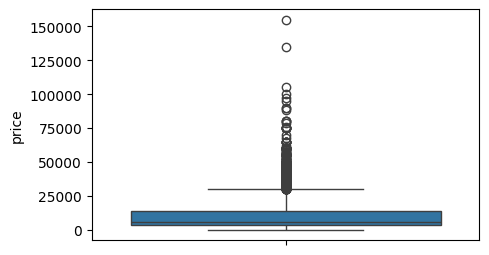

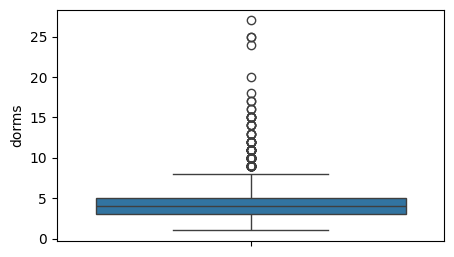

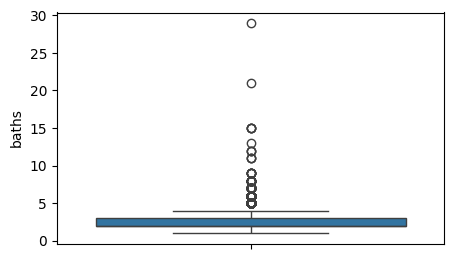

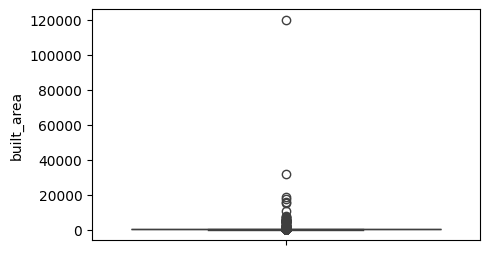

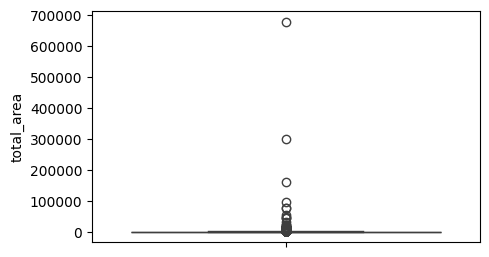

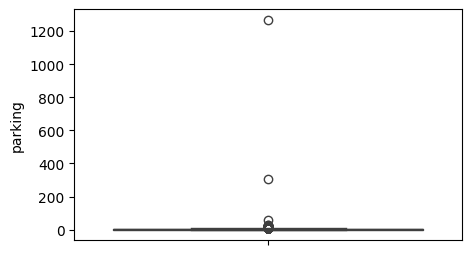

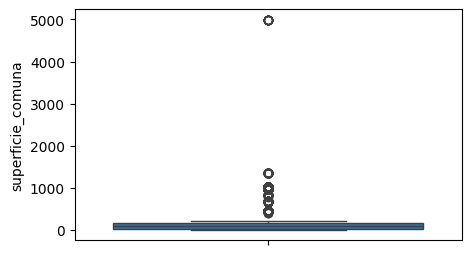

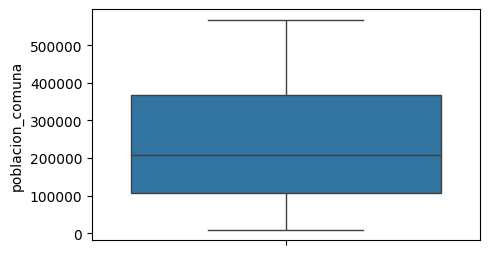

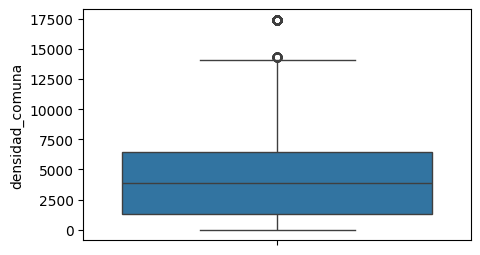

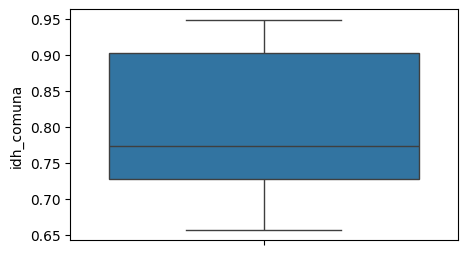

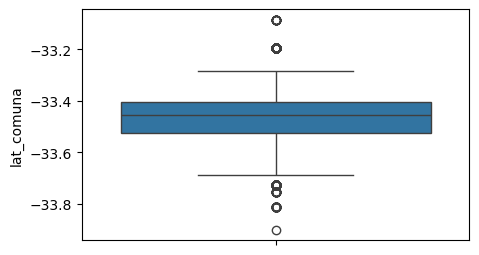

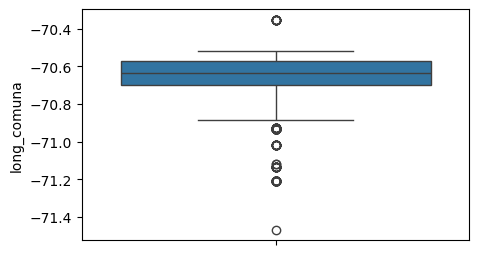

In [681]:
for column in data.columns:
    make_boxplots(data, column) #Mostremos las distribuciones de las features

In [682]:
#Filter data using Inter quantile range
def iqr(data, column): #Inter quantile range
    q3 = data[column].quantile(0.75) #3er cuartil
    q1 = data[column].quantile(0.25) #1er cuartil
    superior_limit = q3 + 1.5*(q3 - q1)
    inferior_limit = q1 - 1.5*(q3 - q1)
    return data[(data[column] < superior_limit) & (data[column] > inferior_limit)] #Selects data

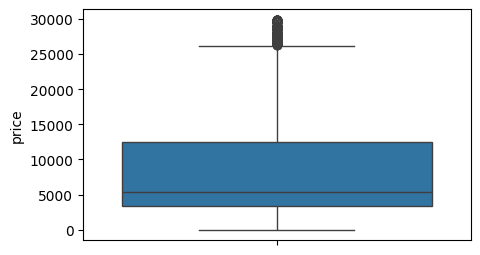

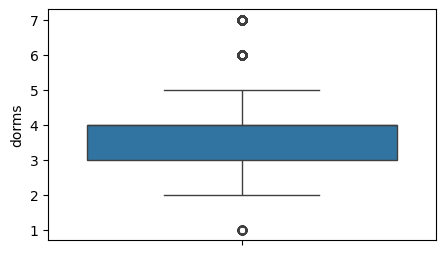

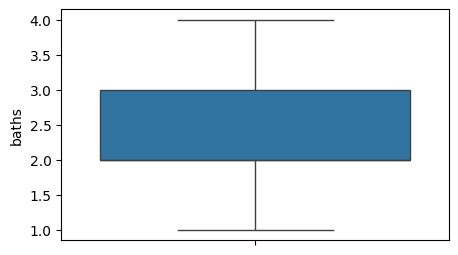

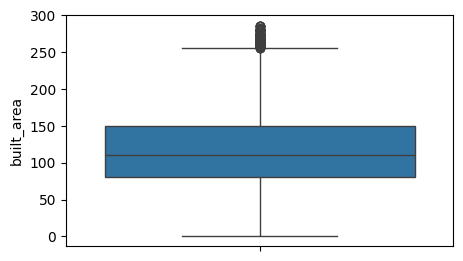

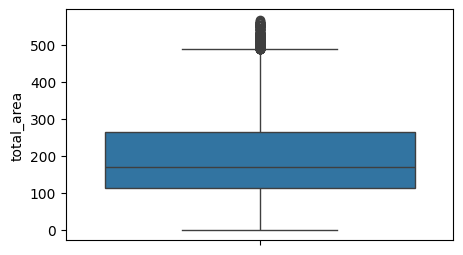

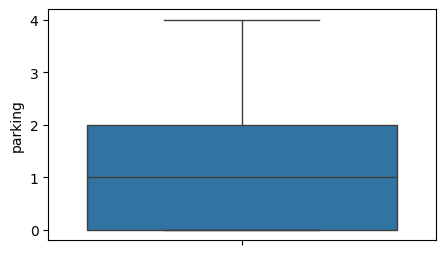

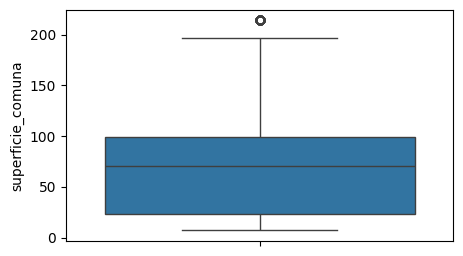

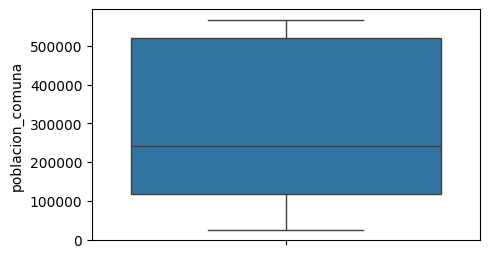

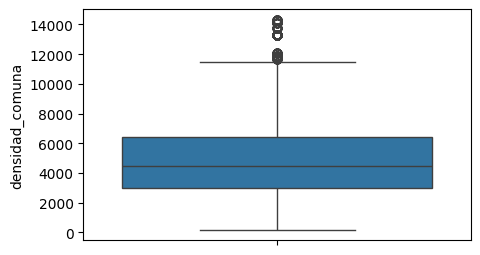

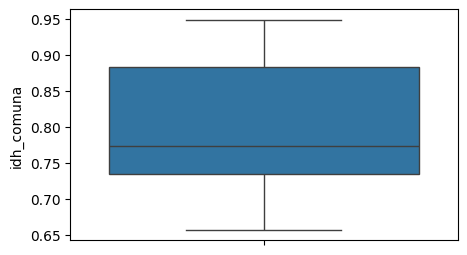

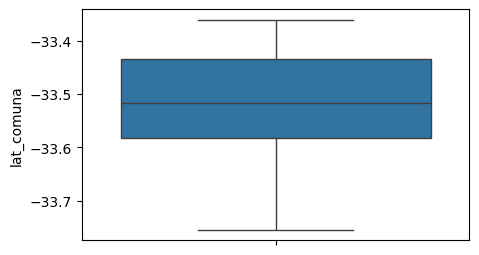

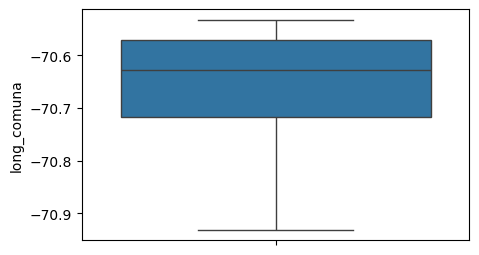

In [683]:
for col in data.columns: #Iteration
    data = iqr(data, col) #Uses IQR
    make_boxplots(data, col) #Plot distr

In [684]:
data #Entonces este es el dataset que vamos a manejar

,price,dorms,baths,built_area,total_area,parking,superficie_comuna,poblacion_comuna,densidad_comuna,idh_comuna,lat_comuna,long_comuna
1,2950,2,1.0,112.0,145.0,1.0,10.0,101174.0,10117.4,0.708,-33.4661,-70.6336
2,3600,3,1.0,59.0,243.0,2.0,15.0,147041.0,9802.7,0.735,-33.4589,-70.6989
5,2641,2,1.0,72.0,131.0,0.0,15.0,147041.0,9802.7,0.735,-33.4589,-70.6989
7,2950,2,1.0,50.0,120.0,1.0,70.2,366916.0,5226.7,0.804,-33.5250,-70.5378
8,2135,3,1.0,72.0,72.0,1.0,135.5,521657.0,3849.6,0.902,-33.5167,-70.7667
...,...,...,...,...,...,...,...,...,...,...,...,...
7768,5300,4,2.0,114.0,220.0,3.0,15.0,147041.0,9802.7,0.735,-33.4589,-70.6989
7769,1264,3,2.0,40.0,50.0,1.0,7.0,98804.0,14114.9,0.657,-33.5219,-70.6869
7772,2390,5,1.0,120.0,76.0,1.0,155.0,301313.0,1943.9,0.712,-33.5819,-70.6869
7775,6800,4,2.0,124.0,200.0,1.0,54.0,241599.0,4474.1,0.743,-33.4861,-70.5333


<Axes: >

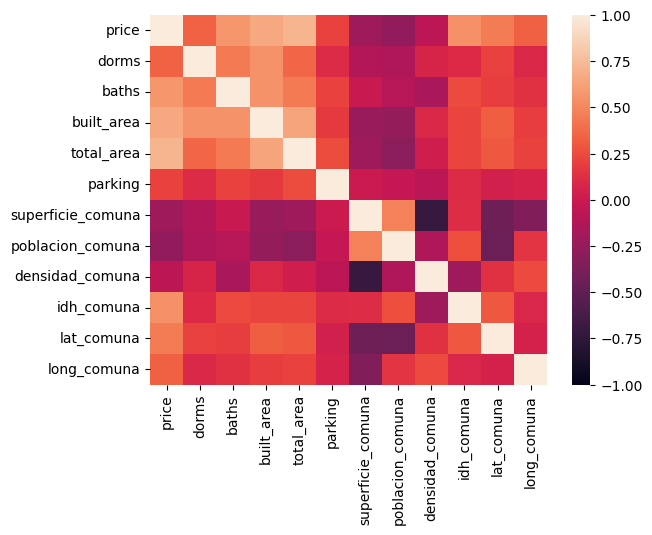

In [685]:
sns.heatmap(data.corr(), vmin=-1, vmax=1) #Veamos la correlación de todas las features
#Fíjense en la correlación negativa superficie_comuna con densidad_comuna. Tiene bastante sentido, a mayor superficie (denominador), menor es su densidad poblacional
#El area total y el area construida tienen una correlación positiva. Así como el area construida y los baños y dormitorios.

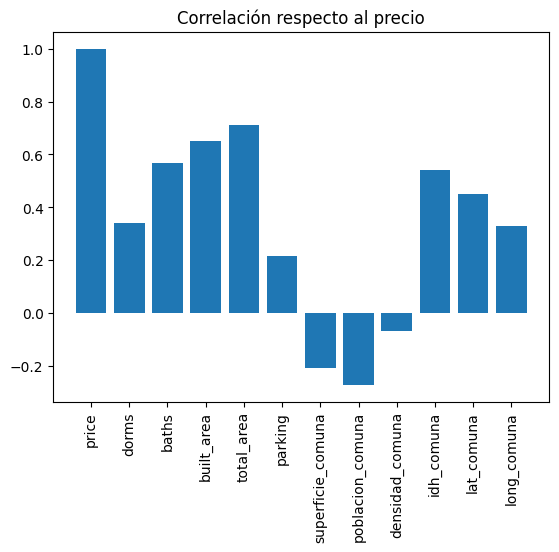

In [686]:
plt.bar(height = data.corr()["price"], x = data.corr()["price"].index)
plt.title("Correlación respecto al precio")
plt.xticks(rotation=90)
plt.show()
#Podemos decir que la densidad comunal es agnóstica al precio de la vivienda.
#Las únicas features con una correlación negativa son la superficie de la comuna y su población.
#Respecto al resto de features, mientras mas tenga, mas caro.

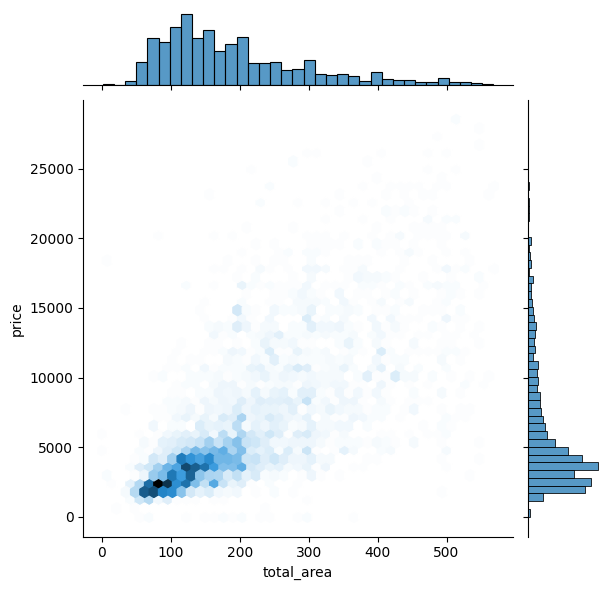

In [687]:
sns.jointplot(data, x = "total_area", y = "price", kind="hex") #Por ejemplo, correlación entre el area total y el precio

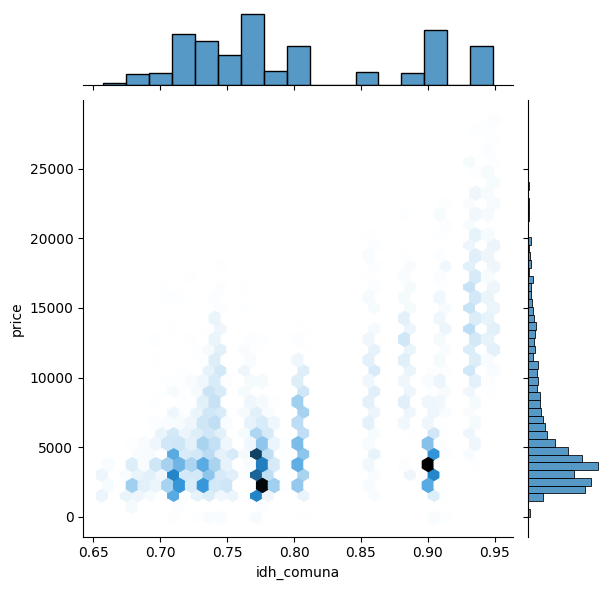

In [688]:
sns.jointplot(data, x = "idh_comuna", y = "price", kind="hex") #Por ejemplo, correlación entre el IDH y el precio

In [689]:
## Con eso terminamos la etapa de feature engineering y EDA, vamos a hacer ML ahora :D

## Training model

In [690]:
y = data.price #Dejemos en la variable X las features
X = data.drop(columns="price") #Y en y a la respuesta (price)

In [691]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) #Separemos los datos en conjuntos de training y testing

In [692]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train) #Primero, estandaricemos los datos (Siempre es una buena idea)
X_test = ss.transform(X_test) #Recuerden que se debe tomar como referencia al conjunto de training y luego aplicar al testing
#Nunca estandarizar todo junto!!

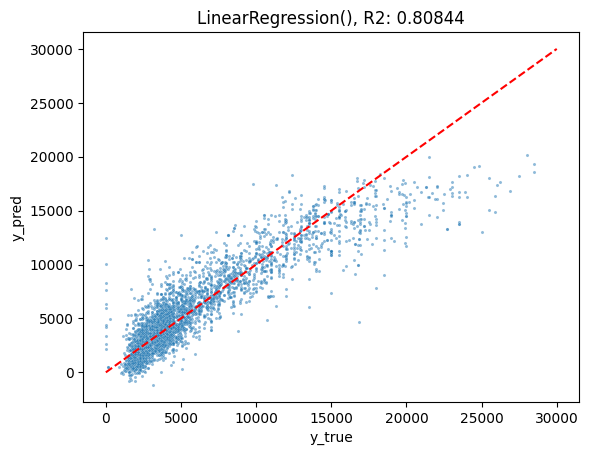

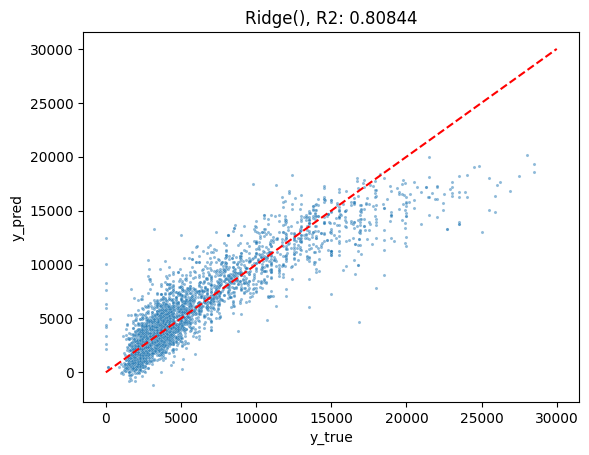

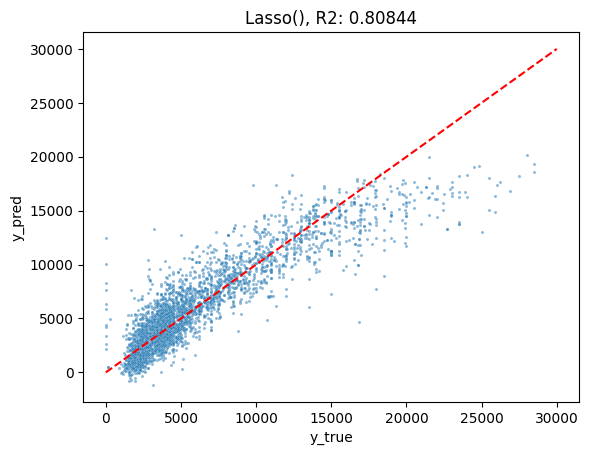

In [693]:
#Entrenemos sin cross validation primero
for lr in LinearRegression(), Ridge(), Lasso(): #Probemos los 3 modelos que vimos en clases
    lr.fit(X_train, y_train) #Entrenamos
    y_pred = lr.predict(X_train) #Predecimos
    sns.scatterplot(x = y_train, y = y_pred, alpha=0.5, s=5) #Este es el comportamiento del modelo lineal
    plt.plot([0,30000], [0,30000], c = "red", linestyle="--") #Hacemos una linea diagonal para representar un modelo "perfecto"
    plt.title(f"{lr.__str__()}, R2: { round(lr.score(X_train, y_train), 5)}") #Imprimimos el nombre del modelo y su R2
    plt.xlabel("y_true")
    plt.ylabel("y_pred")
    plt.show()
    #Las 3 se ven mas o menos igual

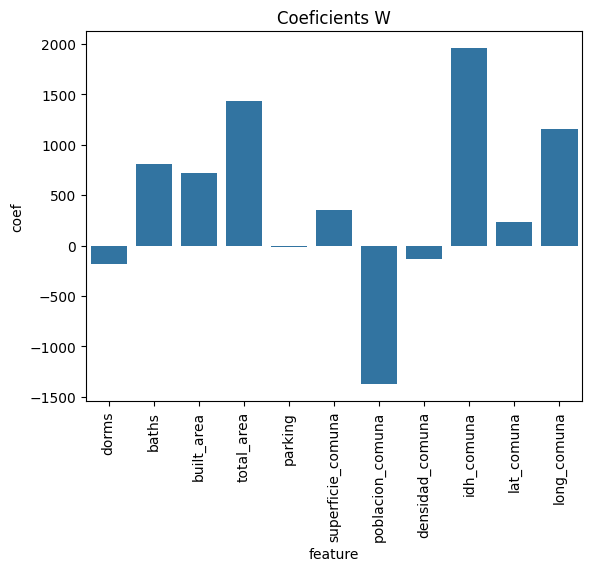

In [694]:
lr = LinearRegression() #Entrenemos un modelo lineal simple
lr.fit(X_train, y_train)
coefs = pd.DataFrame(lr.coef_, columns=["coef"]) #Obtengamos los coeficientes / pesos / w.
coefs["feature"] = X.columns #Agreguemos el nombre de la columna asociado a ese coeficiente.
sns.barplot(coefs, y="coef", x="feature")
plt.xticks(rotation=90)
plt.title("Coeficients W")
plt.show() #Podemos interpretar la "importancia" de las features al momento de predecir respecto al precio.
#Fíjense que una comuna con mayor población impacta negatívamente en el precio de las casas.
#El IDH de la comuna parece ser el factor mas importante al momento de encarecer una propiedad.
#Podemos dar una interpretación a la posición tambien. Comunas que quedan mas hacia el oeste parecen tener un factor positivo al momento de valorar la casa. 
#Lógicamente, el área total de la propiedad encarece la casa

In [695]:
#El intercept o bias corresponde al valor que tendría una casa si todas sus features fueran equivalentes a 0.
float(lr.intercept_)

6001.8107352529805

In [696]:
#Evaluemos la generalización del modelo usando cross validation. 
lr = LinearRegression()
cv_score = cross_validate(lr, X_train, y_train)["test_score"]
print("Mean cv:", float(cv_score.mean().round(3)), "Std cv:", float(cv_score.std().round(3)))
#La desviación estandar es muy pequeña (2er decimal) y si bien el R2 disminuye un poco, no es tan significativo. 

Mean cv: 0.805 Std cv: 0.015


In [697]:
def train_poly(X_train, y_train, degree): #Hagamos esta función para entrenar un pipeline incorporando un termino polinomial y una regresion l2
    #Finalmente, agreguemos un término polinomial a la regresión. 
    pf = PolynomialFeatures(degree = degree) #Transforma la matriz agregando terminos polinomiales
    lr = Ridge() #Apply linear regr + L2 norm
    pipe = Pipeline( #Concatenar procesos
        [
            ("polynomial", pf),
            ("linear regression", lr)
        ]
    )
    cv_score = cross_validate(pipe, X_train, y_train)["test_score"] #Entrenemos usando cross validation
    print("Mean cv:", float(cv_score.mean().round(3)), "Std cv:", float(cv_score.std().round(3)), end="\n")

In [698]:
for degree in range(1, 6):
    print("Degree:", degree)
    train_poly(X_train, y_train, degree)
#Nuestro máximo desempeño lo logramos con una función de grado 2. Con este grado la desviación estandar sigue siendo pequeña (~1.5%)
#A mayor grado aumenta la dispersión. Recuerden Bias - Variance decomposition.

Degree: 1
Mean cv: 0.805 Std cv: 0.015
Degree: 2
Mean cv: 0.867 Std cv: 0.01
Degree: 3
Mean cv: 0.861 Std cv: 0.015
Degree: 4
Mean cv: 0.593 Std cv: 0.146
Degree: 5
Mean cv: -6.19 Std cv: 4.022


In [699]:
#Verifiquemos el desepeño en nuevos datos (X_test)
degree = 2 #Usemos el grado 2
pf = PolynomialFeatures(degree = degree) #Transforma la matriz agregando terminos polinomiales
lr = Ridge() #Apply linear regr + L2 norm
pipe = Pipeline( #Concatenar procesos
    [
        ("polynomial", pf),
        ("linear_regression", lr)
    ]
)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [700]:
print("RMSE", np.sqrt(mean_squared_error(y_test, y_pred))) #Nuestro error promedio en la misma unidad de la respuesta (UF)
print("MAE", mean_absolute_error(y_test, y_pred)) #El error absoluto, si no nos interesan tanto los outliers.
print("R2", r2_score(y_test, y_pred)) #Nuestra varianza explicada ~0.9
print("r", np.sqrt(r2_score(y_test, y_pred))) #El coeficiente de correlación r es la raiz del r^2

RMSE 1551.2416982406774
MAE 1073.3528952903057
R2 0.8876124802555087
r 0.9421318805005532


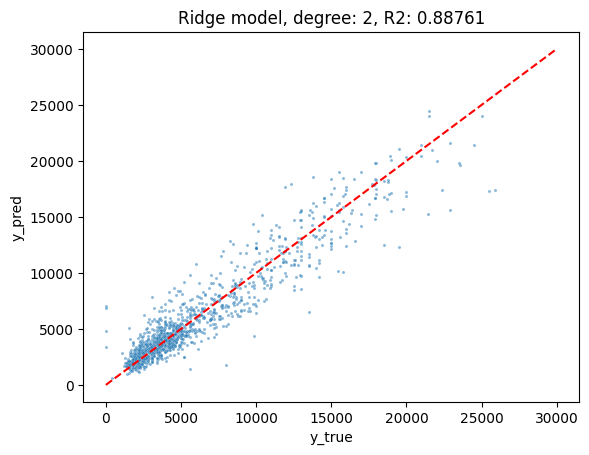

In [701]:

sns.scatterplot(x = y_test, y = y_pred, alpha=0.5, s=5) #Este es el comportamiento del modelo lineal
plt.plot([0,30000], [0,30000], c = "red", linestyle="--") #Hacemos una linea diagonal
plt.title(f"Ridge model, degree: 2, R2: { round(pipe.score(X_test, y_test), 5)}")
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.show()